# Level-1

In [7]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.io import wavfile 
from scipy.io.wavfile import write
import os
import argparse 
from pathlib import Path
from hmmlearn import hmm
from python_speech_features import mfcc, logfbank


MFCC:
Number of windows = 24
Length of each feature = 13

Filter bank:
Number of windows = 24
Length of each feature = 26


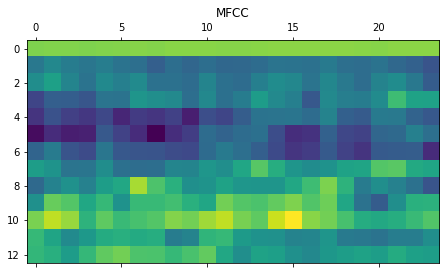

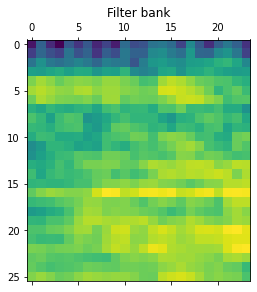

In [11]:
# Read the input audio file
sampling_freq, signal = wavfile.read('test_sound.wav')

# Take the first 1000 samples for analysis
signal = signal[:1000]

# Extract the MFCC features 
features_mfcc = mfcc(signal, sampling_freq)

# Print the parameters for MFCC
print('\nMFCC:\nNumber of windows =', features_mfcc.shape[0])
print('Length of each feature =', features_mfcc.shape[1])

# Plot the features
features_mfcc = features_mfcc.T
plt.matshow(features_mfcc)
plt.title('MFCC')

# Extract the Filter Bank features
features_fb = logfbank(signal, sampling_freq)

# Print the parameters for Filter Bank 
print('\nFilter bank:\nNumber of windows =', features_fb.shape[0])
print('Length of each feature =', features_fb.shape[1])

# Plot the features
features_fb = features_fb.T
plt.matshow(features_fb)
plt.title('Filter bank')

plt.show()

# Level-2

In [10]:
def tone_synthesizer(freq, duration, amplitude, sampling_freq):
    # Construct the time axis 
    time_axis = np.linspace(0, duration, duration * sampling_freq)

    # Construct the audio signal
    signal = amplitude * np.sin(2 * np.pi * freq * time_axis)

    return signal.astype(np.float) 

In [11]:
file_tone_sequence = 'music_00.wav'

mapping_file = 'tone_mapping.json'
    
# Load the tone to frequency map from the mapping file
with open(mapping_file, 'r') as f:
    tone_map = json.loads(f.read())
    
amplitude = 12000
sampling_freq = 44100    # Hz

In [12]:

tone_sequence = [('G', 2), ('D', 2), ('F', 3), ('C', 4), ('A', 2)]
signal = np.array([])

for item in tone_sequence:
    tone_name = item[0]
    freq = tone_map[tone_name]
    duration = item[1]
    synthesized_tone = tone_synthesizer(freq, duration, amplitude, sampling_freq)
    signal = np.append(signal, synthesized_tone, axis=0)
    
write(file_tone_sequence, sampling_freq, signal)


# Level-3

In [25]:
class ModelHMM(object):
    def __init__(self, num_components=4, num_iter=1000):
        self.n_components = num_components
        self.n_iter = num_iter

        self.cov_type = 'diag' 
        self.model_name = 'GaussianHMM' 

        self.models = []

        self.model = hmm.GaussianHMM(n_components=self.n_components,covariance_type=self.cov_type, n_iter=self.n_iter)

    # 'training_data' is a 2D numpy array where each row is 13-dimensional
    def train(self, training_data):
        np.seterr(all='ignore')
        cur_model = self.model.fit(training_data)
        self.models.append(cur_model)

    # Run the HMM model for inference on input data
    def compute_score(self, input_data):
        return self.model.score(input_data)

# Define a function to build a model for each word
def build_models(input_folder):
    # Initialize the variable to store all the models
    speech_models = []

    # Parse the input directory
    for dirname in os.listdir(input_folder):
        # Get the name of the subfolder 
        subfolder = os.path.join(input_folder, dirname)

        if not os.path.isdir(subfolder): 
            continue

        # Extract the label
        label = subfolder[subfolder.rfind('/') + 1:]

        # Initialize the variables
        X = np.array([])

        # Create a list of files to be used for training
        # We will leave one file per folder for testing
        training_files = [x for x in os.listdir(subfolder) if x.endswith('.wav')][:-1]

        # Iterate through the training files and build the models
        for filename in training_files: 
            # Extract the current filepath
            filepath = os.path.join(subfolder, filename)

            # Read the audio signal from the input file
            sampling_freq, signal = wavfile.read(filepath)
            
            # Extract the MFCC features
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                features_mfcc = mfcc(signal, sampling_freq)

            # Append to the variable X
            if len(X) == 0:
                X = features_mfcc
            else:
                X = np.append(X, features_mfcc, axis=0)
            
        # Create the HMM model
        model = ModelHMM()

        # Train the HMM
        model.train(X)

        # Save the model for the current word
        speech_models.append((model, label))

        # Reset the variable
        model = None

    return speech_models

# Define a function to run tests on input files
def run_tests(test_files):
    # Classify input data
    for test_file in test_files:
        # Read input file
        sampling_freq, signal = wavfile.read(test_file)

        # Extract MFCC features
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            features_mfcc = mfcc(signal, sampling_freq)

        # Define variables
        max_score = -float('inf') 
        output_label = None

        # Run the current feature vector through all the HMM
        # models and pick the one with the highest score
        for item in speech_models:
            model, label = item
            score = model.compute_score(features_mfcc)
            if score > max_score:
                max_score = score
                predicted_label = Path(label).name

        # Print the predicted output 
        #start_index = test_file.find('/') + 1
        #end_index = test_file.rfind('/')
        #original_label = test_file[start_index:end_index]
        original_label = Path(test_file).name
        print('\nOriginal: ', original_label) 
        print('Predicted:', predicted_label)


In [26]:
input_folder= r'C:\Users\user\Desktop\Speech_Recognition'
speech_models = build_models(input_folder)
test_files = []
for root, dirs, files in os.walk(input_folder):
    for filename in (x for x in files if '15' in x):
        filepath = os.path.join(root, filename)
        test_files.append(filepath)

run_tests(test_files)


Original:  apple15.wav
Predicted: apple

Original:  banana15.wav
Predicted: banana

Original:  peach15.wav
Predicted: peach

Original:  pineapple15.wav
Predicted: pineapple
